# Initial

In [1]:
# %% #### Imports ####
import pandas as pd
import seaborn as sns
import json
from HSSL import *
from scipy.cluster.hierarchy import cophenet
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import pdist
from benchmark.results import load_all_results

/mnt/large_storage/cabi/hnsw_searchers/HSSL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [3]:
def get_pareto_frontier(df, x, y, split):
    # removes all rows that don't lie on the pareto frontier
    to_plot = df.sort_values(x, ascending=True).reset_index(drop=True)
    d = {} # store last x values
    drop_list = []
    for algo in set(df[split]):
        d[algo] = 0
    for i in range(len(to_plot)):
        x_ = to_plot.iloc[i][x]
        y_ = to_plot.iloc[i][y]
        algo = to_plot.iloc[i][split]
        if y_ > d[algo]:
            d[algo] = y_
        else:
            drop_list.append(i)
    to_plot.drop(drop_list, inplace=True)
        
    return to_plot

# Quality Measurements

## Quality Measurements ALOI hssl

ground-truth cophenetic coefficient: 0.73257971723905
gt_coph_dist took: 416.6478433609009s
coph_dist took: 146.97453570365906s


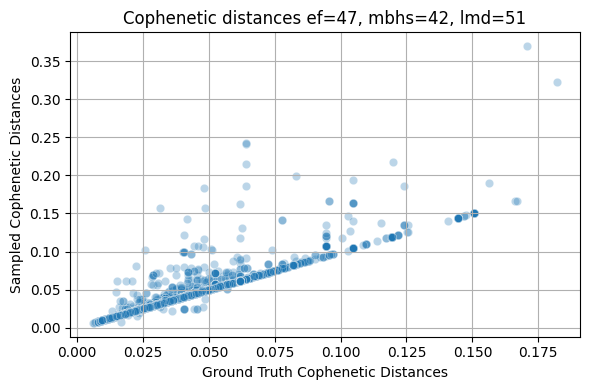

pearson correlation: 0.9485203965734147
cophenetic coefficient: 0.6766578886584593
Pearson took: 398.8048241138458s
coph_dist took: 104.8409252166748s


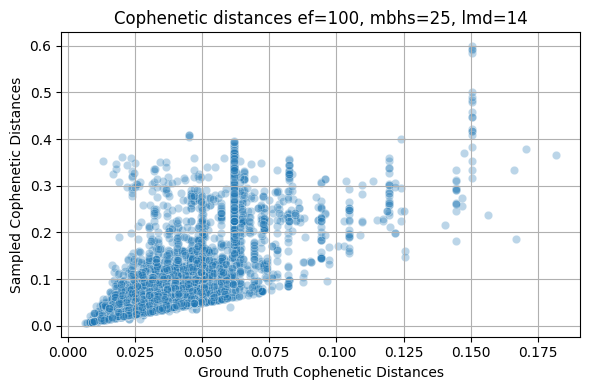

pearson correlation: 0.7748184077658389
cophenetic coefficient: 0.8162838040081252
Pearson took: 378.1140470504761s
coph_dist took: 116.94286727905273s


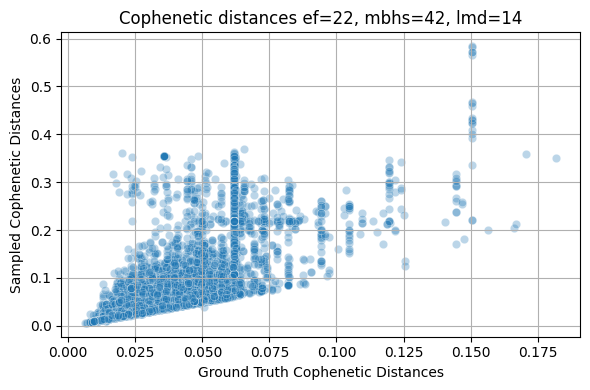

pearson correlation: 0.7840969040484108
cophenetic coefficient: 0.8037675145530039
Pearson took: 339.42212438583374s
coph_dist took: 98.40780448913574s


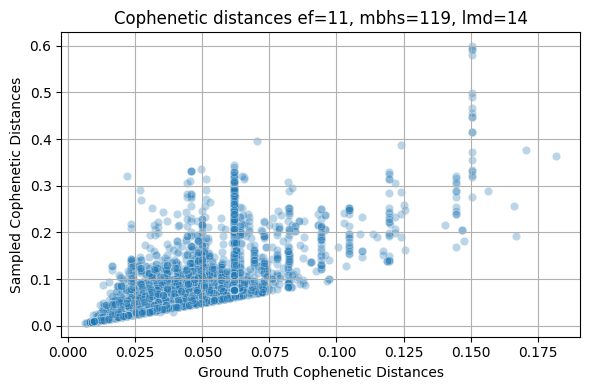

pearson correlation: 0.7276267215418378
cophenetic coefficient: 0.5205647349008257
Pearson took: 308.51189732551575s
coph_dist took: 135.30003833770752s


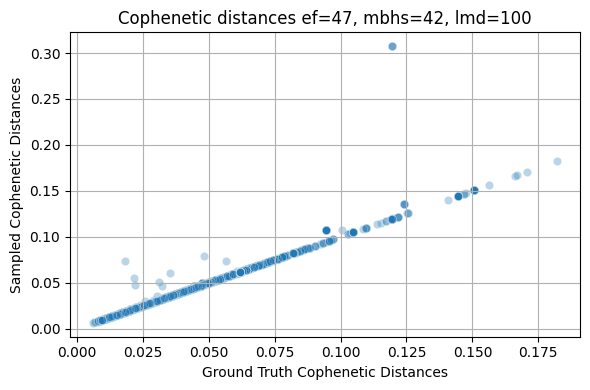

pearson correlation: 0.9889815462301893
cophenetic coefficient: 0.7202802876778513
Pearson took: 475.6159074306488s
coph_dist took: 100.27354288101196s


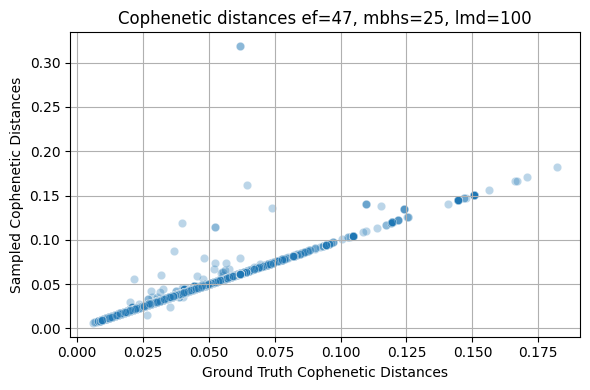

pearson correlation: 0.9825346451147212
cophenetic coefficient: 0.7160822744429295
Pearson took: 316.3155002593994s
coph_dist took: 99.12893581390381s


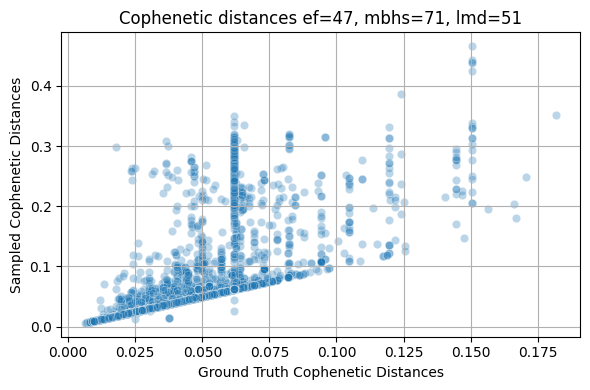

pearson correlation: 0.6723335861688835
cophenetic coefficient: 0.5380166752963285
Pearson took: 332.0997679233551s
coph_dist took: 99.49606323242188s


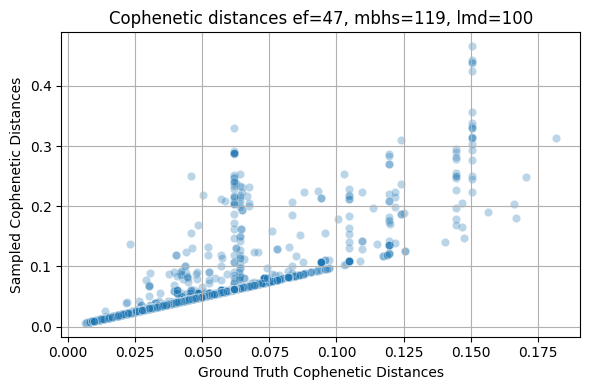

pearson correlation: 0.837568757619991
cophenetic coefficient: 0.5685278567615883
Pearson took: 285.2365918159485s
coph_dist took: 105.37658619880676s


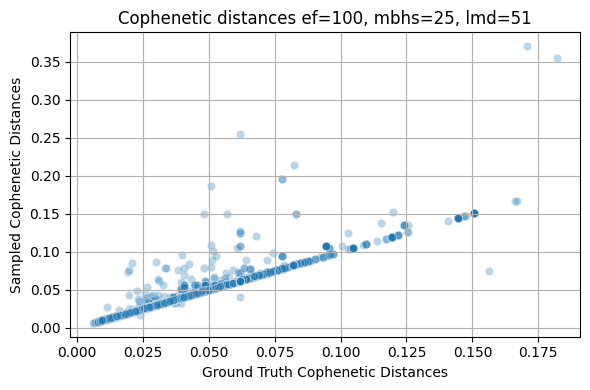

pearson correlation: 0.9690169267270308
cophenetic coefficient: 0.6988109055553826
Pearson took: 318.8842062950134s
coph_dist took: 106.88767743110657s


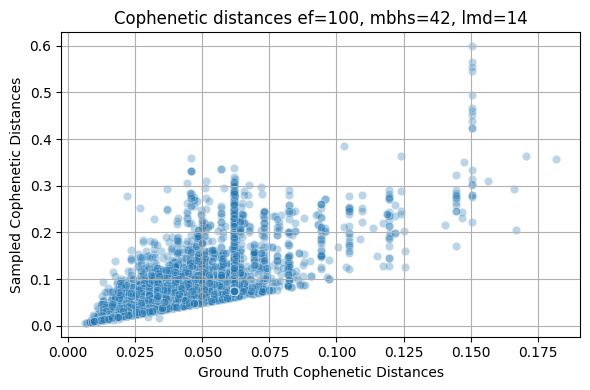

pearson correlation: 0.7171753208644644
cophenetic coefficient: 0.5091017088362515
Pearson took: 320.5644371509552s
coph_dist took: 126.44882941246033s
pearson correlation: 0.6967123287838495
cophenetic coefficient: 0.6595745252438635
Pearson took: 338.9572756290436s
coph_dist took: 98.76432991027832s
pearson correlation: 0.6677473792074275
cophenetic coefficient: 0.5391004769712598
Pearson took: 295.278626203537s
coph_dist took: 114.88273978233337s
pearson correlation: 0.7245442880659702
cophenetic coefficient: 0.7236680889586727
Pearson took: 287.5171685218811s
coph_dist took: 126.0158965587616s
pearson correlation: 0.9852509715742254
cophenetic coefficient: 0.7214803661346164
Pearson took: 350.78977966308594s
coph_dist took: 122.51194453239441s
pearson correlation: 0.8084976838381589
cophenetic coefficient: 0.5437373685847601
Pearson took: 354.5467007160187s
coph_dist took: 118.2896671295166s
pearson correlation: 0.7908445025182883
cophenetic coefficient: 0.5661684854739312
Pearson 

algo         time       n  \
0  HNSWhssl  1259.796838  110000   
1  HNSWhssl   738.393064  110000   
2  HNSWhssl   217.892790  110000   
3  HNSWhssl   148.220747  110000   
4  HNSWhssl  1715.129140  110000   

                                              params  Pearson Correlation  \
0  {"ef": 47, "params": {"higher_max_degree": 25,...             0.948520   
1  {"ef": 100, "params": {"higher_max_degree": 7,...             0.774818   
2  {"ef": 22, "params": {"higher_max_degree": 7, ...             0.784097   
3  {"ef": 11, "params": {"higher_max_degree": 7, ...             0.727627   
4  {"ef": 47, "params": {"higher_max_degree": 50,...             0.988982   

   pval  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [4]:
## -- aloi-hssl -- ##
import time
import itertools


dataset = 'aloi733-110k'

ef = [5, 11, 22, 47, 100]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

combinations = list(itertools.product(ef, mbhs, lmd))

data = []


with h5py.File("data/aloi733-110k.hdf5", "r") as f:
    d = f['data']
    d_array = d[:]
dist_mat = pdist(d_array, metric='euclidean')


for f in load_all_results(dataset, ""):
    try:
        if f.attrs['algo'] != 'scipy': continue
        gt_dendro = f["dendrogram"][:]
        gt_dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in gt_dendro]
        gt_dendro = elki_sort_dendrogram(gt_dendro)
        start = time.time()
        gt_coph_dists = cophenet(gt_dendro)
        coph_coeff_true, _ = cophenet(gt_dendro, dist_mat)
        print(f"ground-truth cophenetic coefficient: {coph_coeff_true}")
        end = time.time()
        t = end - start
        print(f"gt_coph_dist took: {t}s")
    finally:
        f.close()

indices = np.random.choice(gt_coph_dists.shape[0], size=10_000_000, replace=False)

temp = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWhssl": continue
    params = json.loads(f.attrs["params"])
    
    if (params['ef'], 
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        start = time.time()
        coph_dists = cophenet(dendro)
        end = time.time()
        t = end - start
        print(f"coph_dist took: {t}s")

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Cophenetic distances ef={params['ef']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        pear_corr, p_val = pearsonr(sampled_gt_coph_dists, sampled_coph_dists)
        coph_coeff, _ = cophenet(dendro, dist_mat)
        print(f"pearson correlation: {pear_corr}")
        print(f"cophenetic coefficient: {coph_coeff}")
        end = time.time()
        t = end - start
        print(f"Pearson took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "Pearson Correlation": pear_corr,
        "pval": p_val
        })
    finally:
        f.close()

df_ALOIhssl = pd.DataFrame(data=data)
df_ALOIhssl.head(5)

In [5]:
df_ALOIhssl_split = df_ALOIhssl
df_ALOIhssl_split["params_dict"] = df_ALOIhssl_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOIhssl_split["params_dict"].apply(lambda d: d.get("ef")).rename("ef").to_frame()
df_params = df_ALOIhssl_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOIhssl_split = pd.concat([df_ALOIhssl_split, df_ef[['ef']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOIhssl_split

algo         time       n  \
0   HNSWhssl  1259.796838  110000   
1   HNSWhssl   738.393064  110000   
2   HNSWhssl   217.892790  110000   
3   HNSWhssl   148.220747  110000   
4   HNSWhssl  1715.129140  110000   
..       ...          ...     ...   
74  HNSWhssl   853.426750  110000   
75  HNSWhssl  1984.196803  110000   
76  HNSWhssl   524.081302  110000   
77  HNSWhssl   849.265841  110000   
78  HNSWhssl   333.024967  110000   

                                               params  Pearson Correlation  \
0   {"ef": 47, "params": {"higher_max_degree": 25,...             0.948520   
1   {"ef": 100, "params": {"higher_max_degree": 7,...             0.774818   
2   {"ef": 22, "params": {"higher_max_degree": 7, ...             0.784097   
3   {"ef": 11, "params": {"higher_max_degree": 7, ...             0.727627   
4   {"ef": 47, "params": {"higher_max_degree": 50,...             0.988982   
..                                                ...                  ...   
74  {"ef": 100, "params": {"higher_max_degree": 7,...             0.751779   
75  {"ef": 100, "params": {"higher_max_degree": 25...             0.715624   
76  {"ef": 11, "params": {"higher_max_degree": 25,...             0.962845   
77  {"ef": 11, "params": {"higher_max_degree": 50,...             0.842367   
78  {"ef": 22, "params": {"higher_max_degree": 13,...             0.700388   

    pval                                        params_dict   ef  \
0    0.0  {'ef': 47, 'params': {'higher_max_degree': 25,...   47   
1    0.0  {'ef': 100, 'params': {'higher_max_degree': 7,...  100   
2    0.0  {'ef': 22, 'params': {'higher_max_degree': 7, ...   22   
3    0.0  {'ef': 11, 'params': {'higher_max_degree': 7, ...   11   
4    0.0  {'ef': 47, 'params': {'higher_max_degree': 50,...   47   
..   ...                                                ...  ...   
74   0.0  {'ef': 100, 'params': {'higher_max_degree': 7,...  100   
75   0.0  {'ef': 100, 'params': {'higher_max_degree': 25...  100   
76   0.0  {'ef': 11, 'params': {'higher_max_degree': 25,...   11   
77   0.0  {'ef': 11, 'params': {'higher_max_degree': 50,...   11   
78   0.0  {'ef': 22, 'params': {'higher_max_degree': 13,...   22   

    lowest_max_degree  max_build_heap_size  
0                  51                   42  
1                  14                   25  
2                  14                   42  
3                  14                  119  
4                 100                   42  
..                ...                  ...  
74                 14                   71  
75                 51                  200  
76                 51                   25  
77                100                  119  
78                 26                   42  

[79 rows x 10 columns]

In [6]:
df_ALOIhssl_split.to_csv('ALOIhssl_pearson.csv', index=False)

In [7]:
df_ALOIhssl_split = df_ALOIhssl_split[["algo", "time", "Pearson Correlation", "ef", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloihssl = get_pareto_frontier(df_ALOIhssl_split, "time", "Pearson Correlation", "algo")

pareto_aloihssl[["time", "Pearson Correlation", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  ef  max_build_heap_size  \
0   148.220747             0.727627  11                  119   
1   151.263854             0.759031   5                   25   
3   217.892790             0.784097  22                   42   
22  432.355709             0.952817   5                   25   
26  524.081302             0.962845  11                   25   
27  551.127508             0.984757   5                   25   
49  911.739356             0.991963   5                   71   

    lowest_max_degree  
0                  14  
1                  14  
3                  14  
22                 51  
26                 51  
27                100  
49                100

In [8]:
filtered_df = pareto_aloihssl[pareto_aloihssl["Pearson Correlation"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "Pearson Correlation", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  ef  max_build_heap_size  \
22  432.355709             0.952817   5                   25   

    lowest_max_degree  
22                 51

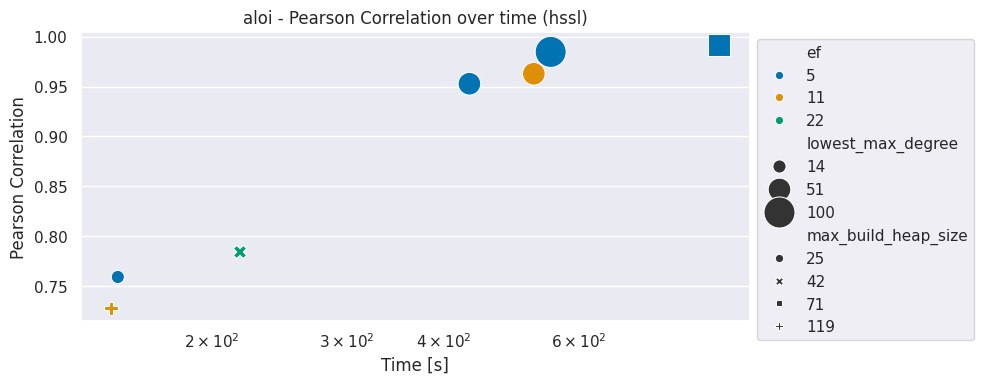

In [9]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloihssl, x="time", y="Pearson Correlation", 
                hue="ef",
                style="max_build_heap_size", 
                size="lowest_max_degree", 
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - Pearson Correlation over time (hssl)")
plt.xlabel("Time [s]")
plt.ylabel("Pearson Correlation")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements ALOI Kruskal

{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override'

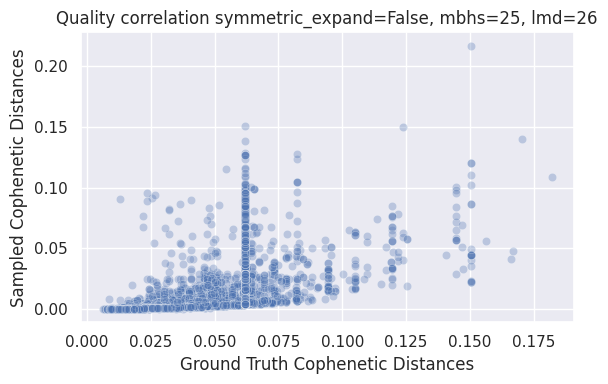

pearson correlation: 0.5480044918881859
cophenetic coefficient: 0.48739778627811947
Pearson took: 279.03146028518677s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': Non

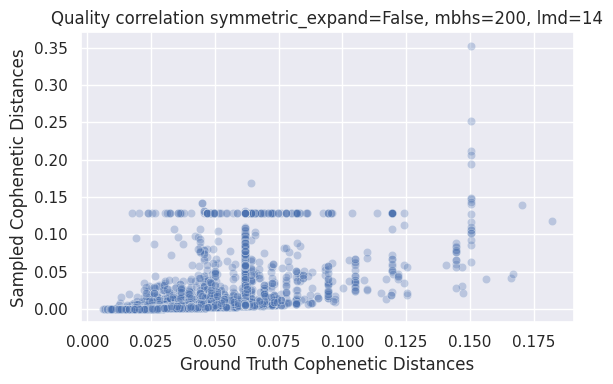

pearson correlation: 0.5928606455792714
cophenetic coefficient: 0.6744740338165035
Pearson took: 288.22970509529114s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 18, 'lowest_max_degree': 37, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 18, 'lowest_max_degree': 37, 'max_layers': No

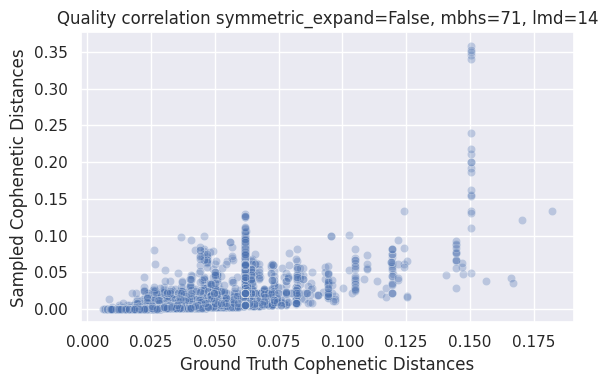

pearson correlation: 0.6540150293089831
cophenetic coefficient: 0.5714975931595495
Pearson took: 284.0013289451599s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 25, 'lowest_max_degree': 51, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 104.5304799079895s


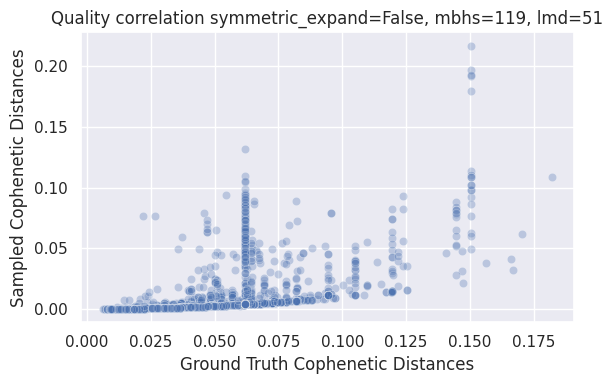

pearson correlation: 0.4965502204349739
cophenetic coefficient: 0.33346730020913795
Pearson took: 288.109911441803s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 112.02275538444519s


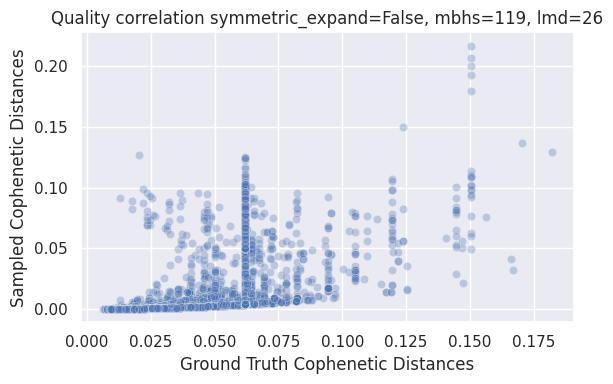

pearson correlation: 0.5513847006880359
cophenetic coefficient: 0.5500698332834943
Pearson took: 324.83024525642395s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 7, 'lowest_max_degree': 14, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 25, 'lowest_max_degree': 51, 'max_layers': None

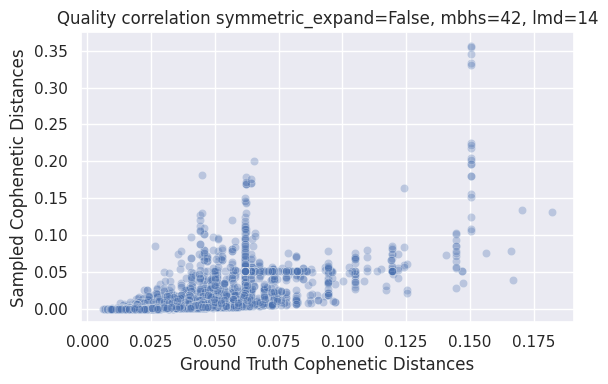

pearson correlation: 0.7653231645404985
cophenetic coefficient: 0.7804560661497306
Pearson took: 306.90982699394226s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 97.35505604743958s


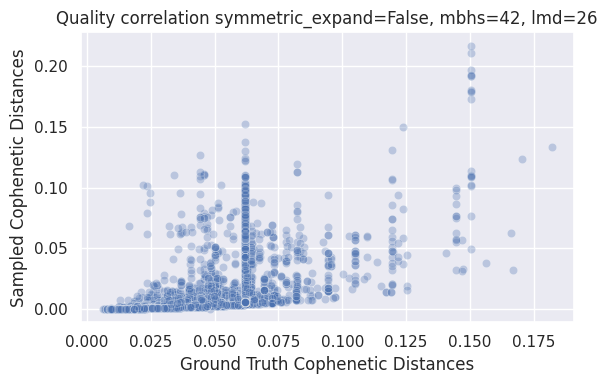

pearson correlation: 0.5428411839880917
cophenetic coefficient: 0.45642974139110976
Pearson took: 283.7468500137329s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 7, 'lowest_max_degree': 14, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 96.34235787391663s


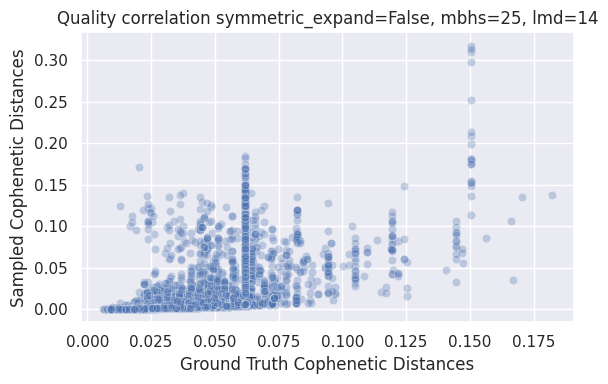

pearson correlation: 0.6671856084808176
cophenetic coefficient: 0.7504083654679298
Pearson took: 275.33848428726196s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None

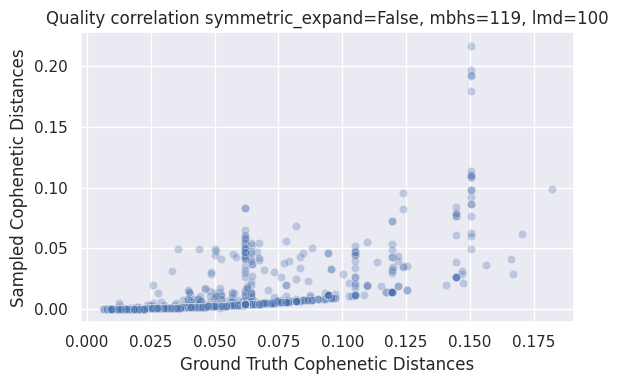

pearson correlation: 0.5505727652013634
cophenetic coefficient: 0.31435849430417073
Pearson took: 296.0718915462494s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': Non

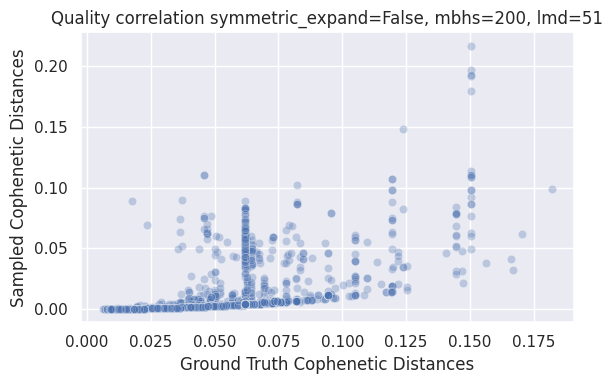

pearson correlation: 0.5162565802055827
cophenetic coefficient: 0.34250279290729363
Pearson took: 292.16691493988037s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers':

algo       time       n  \
0  HNSWkruskal  20.483412  110000   
1  HNSWkruskal  22.424158  110000   
2  HNSWkruskal  23.396780  110000   
3  HNSWkruskal  29.983921  110000   
4  HNSWkruskal  19.457742  110000   

                                              params  Pearson Correlation  \
0  {"minPts": 1, "symmetric_expand": false, "para...             0.548004   
1  {"minPts": 1, "symmetric_expand": false, "para...             0.592861   
2  {"minPts": 1, "symmetric_expand": false, "para...             0.654015   
3  {"minPts": 1, "symmetric_expand": false, "para...             0.496550   
4  {"minPts": 1, "symmetric_expand": false, "para...             0.551385   

   pval  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [10]:
## -- aloi-kruskal -- ##
import time
import itertools

dataset = 'aloi733-110k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWkruskal": continue
    params = json.loads(f.attrs["params"])
    print(params)
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        print(len(dendro))
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1
            continue

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation symmetric_expand={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        pear_corr, p_val = pearsonr(sampled_gt_coph_dists, sampled_coph_dists)
        coph_coeff, _ = cophenet(dendro, dist_mat)
        print(f"pearson correlation: {pear_corr}")
        print(f"cophenetic coefficient: {coph_coeff}")
        end = time.time()
        t = end - start
        print(f"Pearson took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "Pearson Correlation": pear_corr,
        "pval": p_val
        })
    finally:
        f.close()

print(error_count)
df_ALOIkruskal = pd.DataFrame(data=data)
df_ALOIkruskal.head(5)

In [11]:
df_ALOIkruskal_split = df_ALOIkruskal
df_ALOIkruskal_split["params_dict"] = df_ALOIkruskal_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOIkruskal_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_ALOIkruskal_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOIkruskal_split = pd.concat([df_ALOIkruskal_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOIkruskal_split

algo       time       n  \
0   HNSWkruskal  20.483412  110000   
1   HNSWkruskal  22.424158  110000   
2   HNSWkruskal  23.396780  110000   
3   HNSWkruskal  29.983921  110000   
4   HNSWkruskal  19.457742  110000   
5   HNSWkruskal  21.675168  110000   
6   HNSWkruskal  19.336518  110000   
7   HNSWkruskal  21.242225  110000   
8   HNSWkruskal  39.380983  110000   
9   HNSWkruskal  29.398487  110000   
10  HNSWkruskal  20.042995  110000   
11  HNSWkruskal  28.957410  110000   
12  HNSWkruskal  35.010701  110000   
13  HNSWkruskal  40.389269  110000   
14  HNSWkruskal  40.840670  110000   
15  HNSWkruskal  20.480727  110000   
16  HNSWkruskal  33.386015  110000   
17  HNSWkruskal  27.363239  110000   
18  HNSWkruskal  28.736077  110000   

                                               params  Pearson Correlation  \
0   {"minPts": 1, "symmetric_expand": false, "para...             0.548004   
1   {"minPts": 1, "symmetric_expand": false, "para...             0.592861   
2   {"minPts": 1, "symmetric_expand": false, "para...             0.654015   
3   {"minPts": 1, "symmetric_expand": false, "para...             0.496550   
4   {"minPts": 1, "symmetric_expand": false, "para...             0.551385   
5   {"minPts": 1, "symmetric_expand": false, "para...             0.765323   
6   {"minPts": 1, "symmetric_expand": false, "para...             0.542841   
7   {"minPts": 1, "symmetric_expand": false, "para...             0.667186   
8   {"minPts": 1, "symmetric_expand": false, "para...             0.550573   
9   {"minPts": 1, "symmetric_expand": false, "para...             0.516257   
10  {"minPts": 1, "symmetric_expand": false, "para...             0.585901   
11  {"minPts": 1, "symmetric_expand": false, "para...             0.514156   
12  {"minPts": 1, "symmetric_expand": false, "para...             0.778968   
13  {"minPts": 1, "symmetric_expand": false, "para...             0.852341   
14  {"minPts": 1, "symmetric_expand": false, "para...             0.543517   
15  {"minPts": 1, "symmetric_expand": false, "para...             0.522156   
16  {"minPts": 1, "symmetric_expand": false, "para...             0.861304   
17  {"minPts": 1, "symmetric_expand": false, "para...             0.711745   
18  {"minPts": 1, "symmetric_expand": false, "para...             0.674178   

    pval                                        params_dict  symmetric_expand  \
0    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26  

In [12]:
df_ALOIkruskal_split.to_csv('ALOIkruskal_pearson.csv', index=False)

In [13]:
df_ALOIkruskal_split = df_ALOIkruskal_split[["algo", "time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloikruskal = get_pareto_frontier(df_ALOIkruskal_split, "time", "Pearson Correlation", "algo")

pareto_aloikruskal[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
0   19.336518             0.542841             False                   42   
1   19.457742             0.551385             False                  119   
2   20.042995             0.585901             False                   71   
5   21.242225             0.667186             False                   25   
6   21.675168             0.765323             False                   42   
14  33.386015             0.861304             False                   25   

    lowest_max_degree  
0                  26  
1                  26  
2                  26  
5                  14  
6                  14  
14                100

In [14]:
filtered_df = pareto_aloikruskal[pareto_aloikruskal["Pearson Correlation"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
14  33.386015             0.861304             False                   25   

    lowest_max_degree  
14                100

In [15]:
pareto_aloikruskal = pareto_aloikruskal[["time", "Pearson Correlation", "max_build_heap_size", "lowest_max_degree"]]

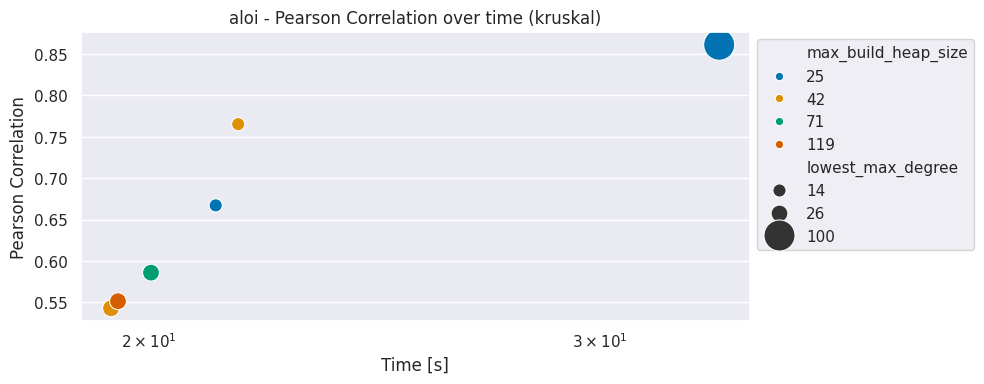

In [16]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloikruskal, x="time", y="Pearson Correlation", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - Pearson Correlation over time (kruskal)")
plt.xlabel("Time [s]")
plt.ylabel("Pearson Correlation")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements ALOI MST

ERROR in cophenet
coph_dist took: 115.6149652004242s


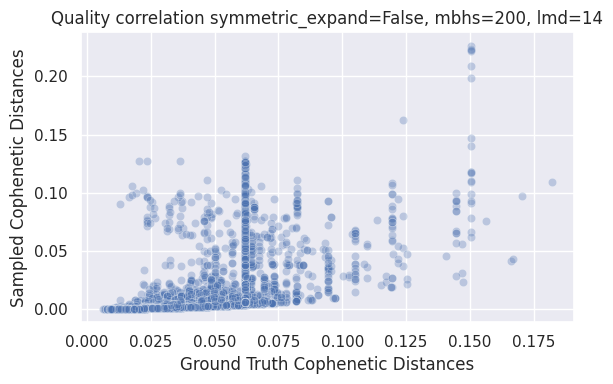

pearson correlation: 0.6500660648931288
cophenetic coefficient: 0.7253569047728178
Pearson took: 285.5209140777588s
coph_dist took: 130.953608751297s


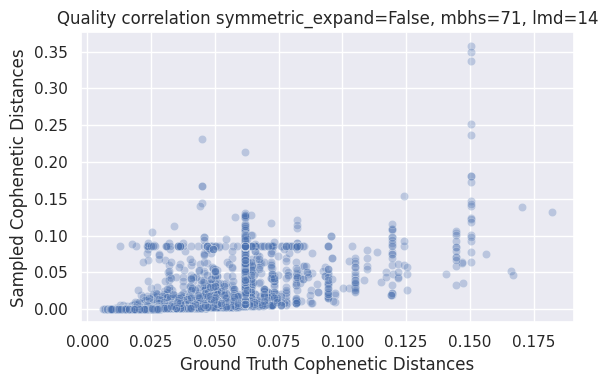

pearson correlation: 0.6638745727127241
cophenetic coefficient: 0.7310938757866332
Pearson took: 288.891494512558s
coph_dist took: 100.10430932044983s


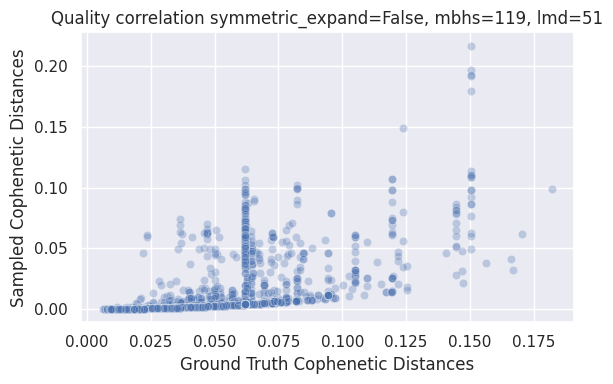

pearson correlation: 0.5145353990769969
cophenetic coefficient: 0.3634001487603052
Pearson took: 276.4280686378479s
coph_dist took: 109.32787823677063s


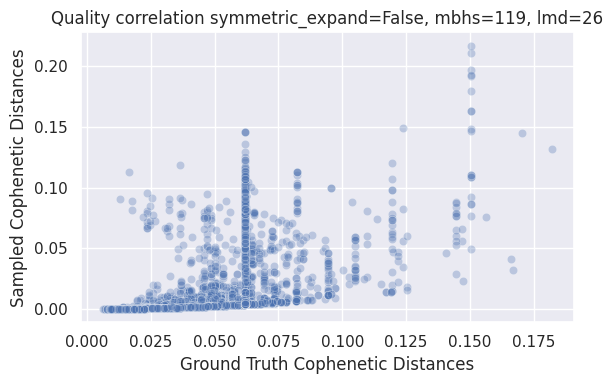

pearson correlation: 0.551532586180066
cophenetic coefficient: 0.5373985560456344
Pearson took: 289.5510983467102s
coph_dist took: 97.18157744407654s


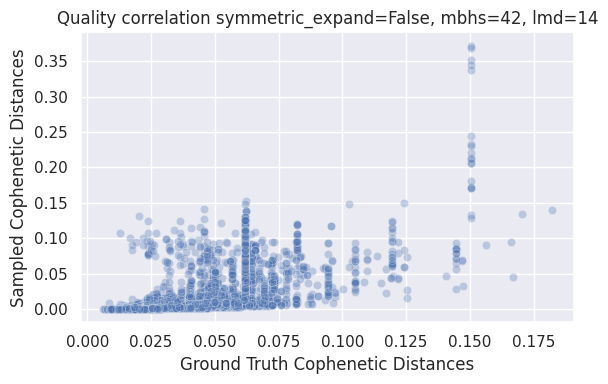

pearson correlation: 0.7144690265506275
cophenetic coefficient: 0.796502162525848
Pearson took: 278.46934270858765s
coph_dist took: 119.33269238471985s


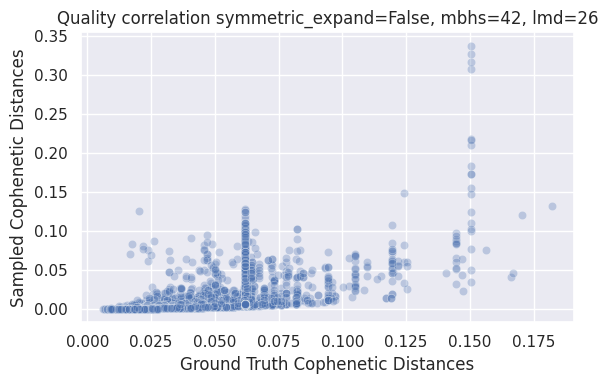

pearson correlation: 0.540090559813971
cophenetic coefficient: 0.4541728447163504
Pearson took: 279.64305806159973s
coph_dist took: 115.64362525939941s


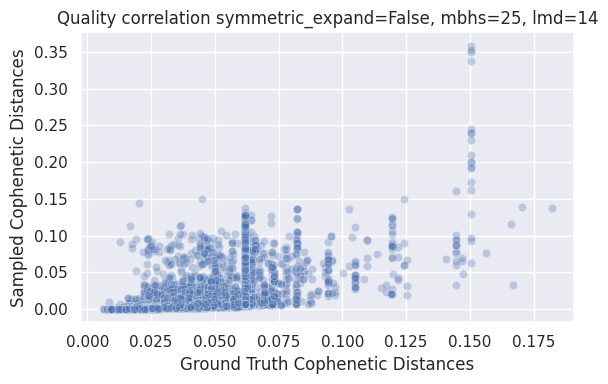

pearson correlation: 0.6825625060087177
cophenetic coefficient: 0.7320415520051655
Pearson took: 281.7423152923584s
coph_dist took: 139.79468631744385s


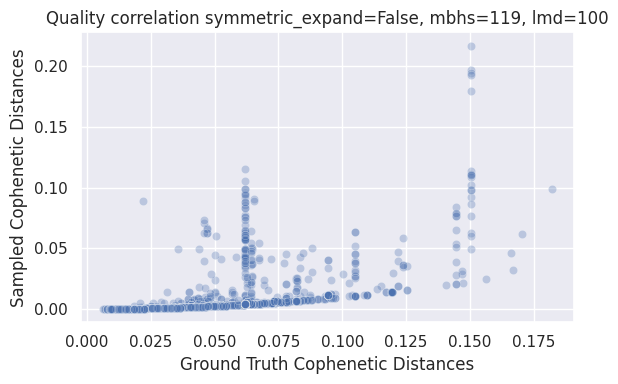

pearson correlation: 0.49576401455752955
cophenetic coefficient: 0.3150126451637807
Pearson took: 282.2286219596863s
coph_dist took: 109.7025887966156s


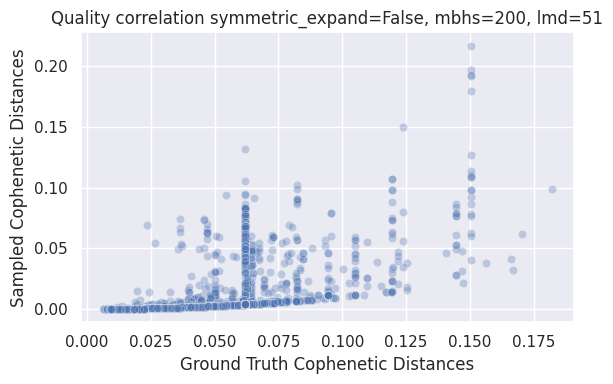

pearson correlation: 0.51341681269553
cophenetic coefficient: 0.3592433975131328
Pearson took: 314.2637257575989s
coph_dist took: 113.53801417350769s


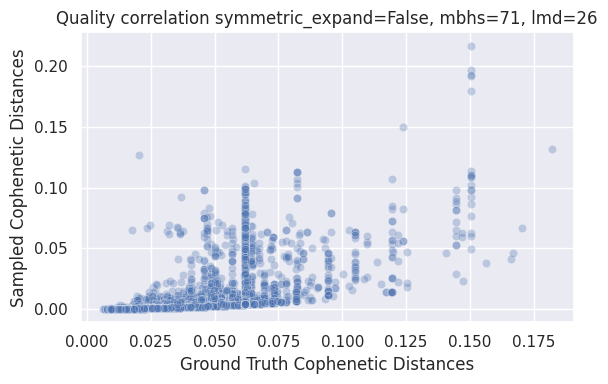

pearson correlation: 0.5396290969906677
cophenetic coefficient: 0.4006662650074638
Pearson took: 303.3353774547577s
coph_dist took: 139.55068469047546s
pearson correlation: 0.5165710758206804
cophenetic coefficient: 0.30949670661341677
Pearson took: 299.8457157611847s
coph_dist took: 122.97268867492676s
pearson correlation: 0.9143998452219582
cophenetic coefficient: 0.5947605540342773
Pearson took: 294.4034595489502s
coph_dist took: 101.50718688964844s
pearson correlation: 0.8654736591457493
cophenetic coefficient: 0.5605327184383277
Pearson took: 306.7210376262665s
coph_dist took: 99.97678756713867s
pearson correlation: 0.5415731134889978
cophenetic coefficient: 0.3119170169593114
Pearson took: 321.3050880432129s
coph_dist took: 102.4675805568695s
pearson correlation: 0.758178139188408
cophenetic coefficient: 0.7075117715961993
Pearson took: 311.1394274234772s
coph_dist took: 124.84627652168274s
pearson correlation: 0.5317678870251614
cophenetic coefficient: 0.34557887404009385
Pearso

algo      time       n  \
0  HNSWmst  1.454089  110000   
1  HNSWmst  1.038746  110000   
2  HNSWmst  2.550881  110000   
3  HNSWmst  1.407947  110000   
4  HNSWmst  1.042305  110000   

                                              params  Pearson Correlation  \
0  {"minPts": 1, "symmetric_expand": false, "para...             0.650066   
1  {"minPts": 1, "symmetric_expand": false, "para...             0.663875   
2  {"minPts": 1, "symmetric_expand": false, "para...             0.514535   
3  {"minPts": 1, "symmetric_expand": false, "para...             0.551533   
4  {"minPts": 1, "symmetric_expand": false, "para...             0.714469   

   pval  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [17]:
## -- aloi-mst -- ##
import time
import itertools

dataset = 'aloi733-110k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWmst": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1
            continue

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation symmetric_expand={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        pear_corr, p_val = pearsonr(sampled_gt_coph_dists, sampled_coph_dists)
        coph_coeff, _ = cophenet(dendro, dist_mat)
        print(f"pearson correlation: {pear_corr}")
        print(f"cophenetic coefficient: {coph_coeff}")
        end = time.time()
        t = end - start
        print(f"Pearson took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "Pearson Correlation": pear_corr,
        "pval": p_val
        })
    finally:
        f.close()

print(error_count)
df_ALOImst = pd.DataFrame(data=data)
df_ALOImst.head(5)

In [18]:
df_ALOImst_split = df_ALOImst
df_ALOImst_split["params_dict"] = df_ALOImst_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOImst_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_ALOImst_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOImst_split = pd.concat([df_ALOImst_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOImst_split

algo      time       n  \
0   HNSWmst  1.454089  110000   
1   HNSWmst  1.038746  110000   
2   HNSWmst  2.550881  110000   
3   HNSWmst  1.407947  110000   
4   HNSWmst  1.042305  110000   
5   HNSWmst  1.488958  110000   
6   HNSWmst  0.998609  110000   
7   HNSWmst  5.380768  110000   
8   HNSWmst  2.864119  110000   
9   HNSWmst  1.443940  110000   
10  HNSWmst  2.661298  110000   
11  HNSWmst  3.118906  110000   
12  HNSWmst  4.436683  110000   
13  HNSWmst  5.469712  110000   
14  HNSWmst  1.168811  110000   
15  HNSWmst  1.606784  110000   
16  HNSWmst  1.952028  110000   
17  HNSWmst  1.894300  110000   
18  HNSWmst  2.186197  110000   

                                               params  Pearson Correlation  \
0   {"minPts": 1, "symmetric_expand": false, "para...             0.650066   
1   {"minPts": 1, "symmetric_expand": false, "para...             0.663875   
2   {"minPts": 1, "symmetric_expand": false, "para...             0.514535   
3   {"minPts": 1, "symmetric_expand": false, "para...             0.551533   
4   {"minPts": 1, "symmetric_expand": false, "para...             0.714469   
5   {"minPts": 1, "symmetric_expand": false, "para...             0.540091   
6   {"minPts": 1, "symmetric_expand": false, "para...             0.682563   
7   {"minPts": 1, "symmetric_expand": false, "para...             0.495764   
8   {"minPts": 1, "symmetric_expand": false, "para...             0.513417   
9   {"minPts": 1, "symmetric_expand": false, "para...             0.539629   
10  {"minPts": 1, "symmetric_expand": false, "para...             0.516571   
11  {"minPts": 1, "symmetric_expand": false, "para...             0.914400   
12  {"minPts": 1, "symmetric_expand": false, "para...             0.865474   
13  {"minPts": 1, "symmetric_expand": false, "para...             0.541573   
14  {"minPts": 1, "symmetric_expand": false, "para...             0.758178   
15  {"minPts": 1, "symmetric_expand": false, "para...             0.531768   
16  {"minPts": 1, "symmetric_expand": false, "para...             0.764163   
17  {"minPts": 1, "symmetric_expand": false, "para...             0.583707   
18  {"minPts": 1, "symmetric_expand": false, "para...             0.667209   

    pval                                        params_dict  symmetric_expand  \
0    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  14                  200  
1                  14                   71  
2                  51        

In [19]:
df_ALOImst_split.to_csv('ALOImst_pearson.csv', index=False)

In [20]:
df_ALOImst_split = df_ALOImst_split[["algo", "time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloimst = get_pareto_frontier(df_ALOImst_split, "time", "Pearson Correlation", "algo")

pareto_aloimst[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
0   0.998609             0.682563             False                   25   
2   1.042305             0.714469             False                   42   
3   1.168811             0.758178             False                  119   
10  1.952028             0.764163             False                   25   
15  3.118906             0.914400             False                   42   

    lowest_max_degree  
0                  14  
2                  14  
3                  14  
10                100  
15                100

In [21]:
filtered_df = pareto_aloimst[pareto_aloimst["Pearson Correlation"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
15  3.118906               0.9144             False                   42   

    lowest_max_degree  
15                100

In [22]:
pareto_aloimst = pareto_aloimst[["time", "Pearson Correlation", "max_build_heap_size", "lowest_max_degree"]]

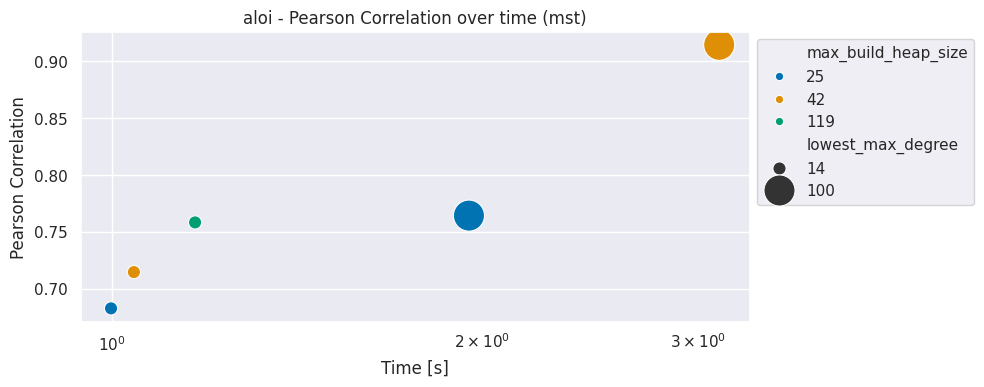

In [23]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloimst, x="time", y="Pearson Correlation", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - Pearson Correlation over time (mst)")
plt.xlabel("Time [s]")
plt.ylabel("Pearson Correlation")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST hssl

ground-truth cophenetic coefficient: 0.44861380740499307
gt_coph_dist took: 138.64171838760376s
coph_dist took: 42.21286749839783s


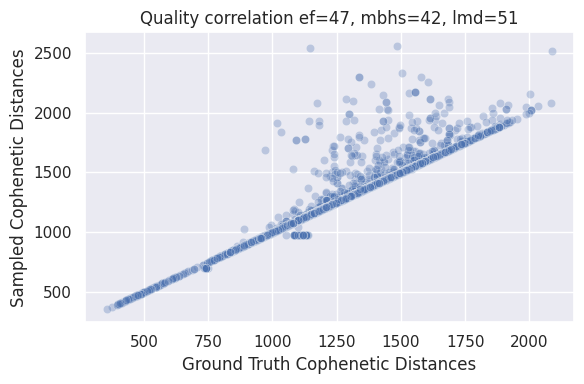

pearson correlation: 0.9715997851133237
cophenetic coefficient: 0.42751637211288185
Pearson took: 96.48990988731384s
coph_dist took: 41.50967741012573s


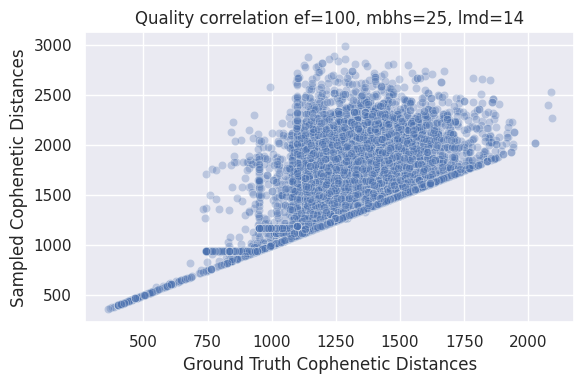

pearson correlation: 0.5670449081880772
cophenetic coefficient: 0.29648325895097655
Pearson took: 94.81434202194214s
coph_dist took: 39.74844431877136s


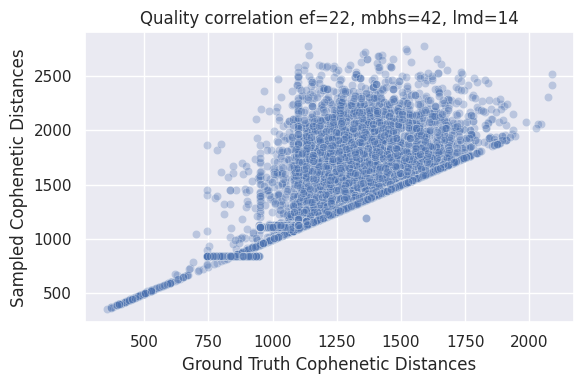

pearson correlation: 0.6357360405072492
cophenetic coefficient: 0.2849358589378777
Pearson took: 92.76478385925293s
coph_dist took: 42.71976065635681s


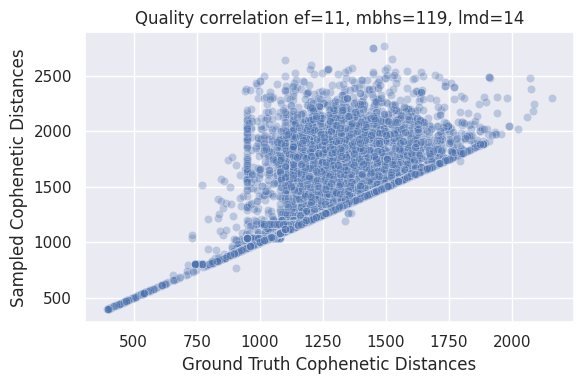

pearson correlation: 0.5973301848722403
cophenetic coefficient: 0.19963513623788068
Pearson took: 95.35789084434509s
coph_dist took: 42.54050087928772s


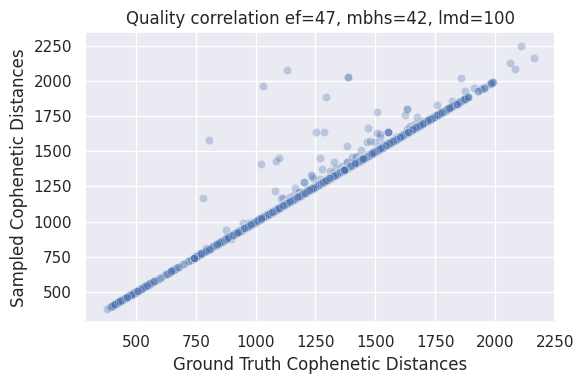

pearson correlation: 0.9961758591339789
cophenetic coefficient: 0.44604384932528746
Pearson took: 94.76527571678162s
coph_dist took: 45.756834745407104s


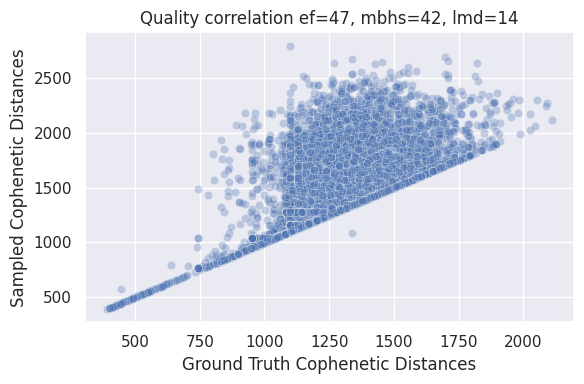

pearson correlation: 0.6591461780132698
cophenetic coefficient: 0.29093574817651124
Pearson took: 100.32933855056763s
coph_dist took: 43.11514139175415s


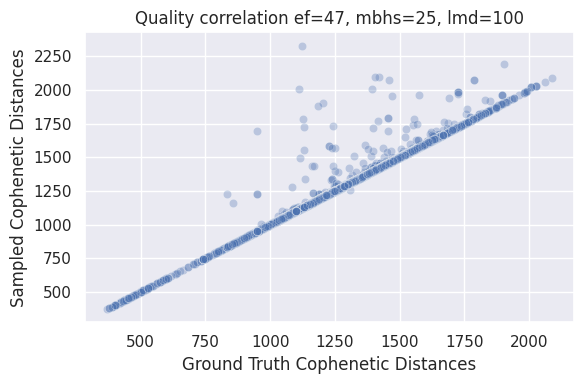

pearson correlation: 0.9877943296747775
cophenetic coefficient: 0.44146387744102
Pearson took: 95.9516077041626s
coph_dist took: 44.032904863357544s


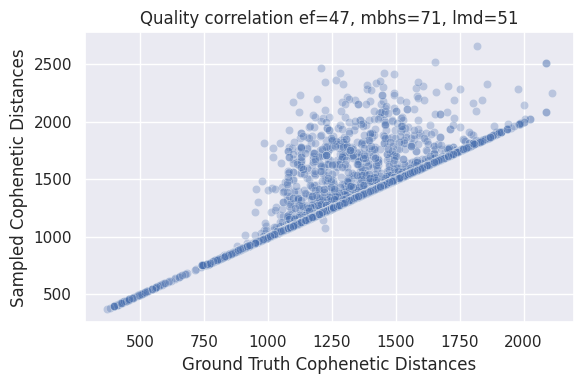

pearson correlation: 0.8860919127375747
cophenetic coefficient: 0.3778020752603146
Pearson took: 96.89892315864563s
coph_dist took: 42.462137937545776s


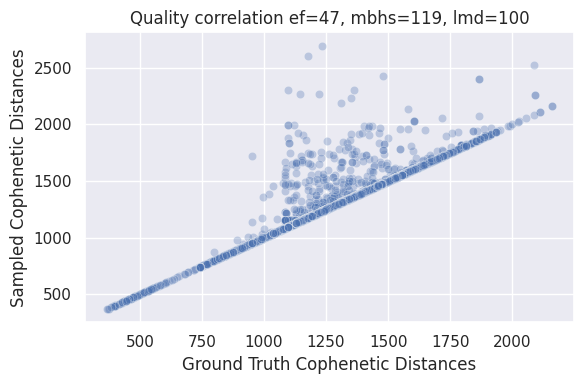

pearson correlation: 0.9620796006178373
cophenetic coefficient: 0.4258252023591333
Pearson took: 95.4369580745697s
coph_dist took: 39.35521650314331s


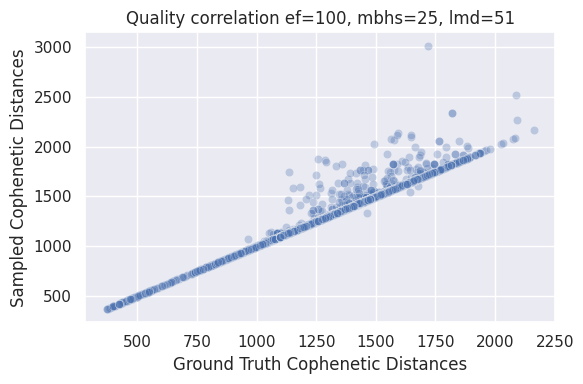

pearson correlation: 0.9880639608372144
cophenetic coefficient: 0.4391777602367779
Pearson took: 90.86971974372864s
coph_dist took: 38.78885078430176s
pearson correlation: 0.586669146801441
cophenetic coefficient: 0.26005151769558993
Pearson took: 89.83164095878601s
coph_dist took: 38.88901925086975s
pearson correlation: 0.7379829306138039
cophenetic coefficient: 0.30756034834775303
Pearson took: 89.9290988445282s
coph_dist took: 42.548434257507324s
pearson correlation: 0.9015107908247207
cophenetic coefficient: 0.3835422837347375
Pearson took: 95.15585827827454s
coph_dist took: 38.73412227630615s
pearson correlation: 0.7018280565665764
cophenetic coefficient: 0.26281934329782575
Pearson took: 90.06180453300476s
coph_dist took: 38.51060366630554s
pearson correlation: 0.9972179187967837
cophenetic coefficient: 0.446565144845313
Pearson took: 89.8430483341217s
coph_dist took: 42.75163149833679s
pearson correlation: 0.7089767676953241
cophenetic coefficient: 0.3001965440636448
Pearson too

algo        time      n  \
0  HNSWhssl  804.777596  70000   
1  HNSWhssl  616.729362  70000   
2  HNSWhssl  179.858649  70000   
3  HNSWhssl  114.302616  70000   
4  HNSWhssl  983.602818  70000   

                                              params  Pearson Correlation  \
0  {"ef": 47, "params": {"higher_max_degree": 25,...             0.971600   
1  {"ef": 100, "params": {"higher_max_degree": 7,...             0.567045   
2  {"ef": 22, "params": {"higher_max_degree": 7, ...             0.635736   
3  {"ef": 11, "params": {"higher_max_degree": 7, ...             0.597330   
4  {"ef": 47, "params": {"higher_max_degree": 50,...             0.996176   

   pval  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [ ]:
## -- mnist-hssl -- ##
import time
import itertools

dataset = 'mnist-70k'

ef = [5, 11, 22, 47, 100]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

combinations = list(itertools.product(ef, mbhs, lmd))

data = []


with h5py.File("data/mnist-70k.hdf5", "r") as f:
    d = f['data']
    d_array = d[:]
dist_mat = pdist(d_array, metric='euclidean')


for f in load_all_results(dataset, ""):
    try:
        if f.attrs['algo'] != 'scipy': continue
        gt_dendro = f["dendrogram"][:]
        gt_dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in gt_dendro]
        gt_dendro = elki_sort_dendrogram(gt_dendro)
        start = time.time()
        gt_coph_dists = cophenet(gt_dendro)
        coph_coeff_true, _ = cophenet(gt_dendro, dist_mat)
        print(f"ground-truth cophenetic coefficient: {coph_coeff_true}")
        end = time.time()
        t = end - start
        print(f"gt_coph_dist took: {t}s")
    finally:
        f.close()
indices = np.random.choice(gt_coph_dists.shape[0], size=10_000_000, replace=False)

temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWhssl": continue
    params = json.loads(f.attrs["params"])
    
    if (params['ef'], 
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1
            continue

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['ef']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        pear_corr, p_val = pearsonr(sampled_gt_coph_dists, sampled_coph_dists)
        coph_coeff, _ = cophenet(dendro, dist_mat)
        print(f"pearson correlation: {pear_corr}")
        print(f"cophenetic coefficient: {coph_coeff}")
        end = time.time()
        t = end - start
        print(f"Pearson took: {t}s")


        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "Pearson Correlation": pear_corr,
        "pval": p_val
        })
    finally:
        f.close()

print(error_count)
df_MNISThssl = pd.DataFrame(data=data)
df_MNISThssl.head(5)

In [25]:
df_MNISThssl_split = df_MNISThssl
df_MNISThssl_split["params_dict"] = df_MNISThssl_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISThssl_split["params_dict"].apply(lambda d: d.get("ef")).rename("ef").to_frame()
df_params = df_MNISThssl_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISThssl_split = pd.concat([df_MNISThssl_split, df_ef[['ef']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISThssl_split

algo         time      n  \
0   HNSWhssl   804.777596  70000   
1   HNSWhssl   616.729362  70000   
2   HNSWhssl   179.858649  70000   
3   HNSWhssl   114.302616  70000   
4   HNSWhssl   983.602818  70000   
..       ...          ...    ...   
95  HNSWhssl  1513.484621  70000   
96  HNSWhssl   198.429513  70000   
97  HNSWhssl   304.447488  70000   
98  HNSWhssl   720.778153  70000   
99  HNSWhssl   267.482976  70000   

                                               params  Pearson Correlation  \
0   {"ef": 47, "params": {"higher_max_degree": 25,...             0.971600   
1   {"ef": 100, "params": {"higher_max_degree": 7,...             0.567045   
2   {"ef": 22, "params": {"higher_max_degree": 7, ...             0.635736   
3   {"ef": 11, "params": {"higher_max_degree": 7, ...             0.597330   
4   {"ef": 47, "params": {"higher_max_degree": 50,...             0.996176   
..                                                ...                  ...   
95  {"ef": 100, "params": {"higher_max_degree": 25...             0.926165   
96  {"ef": 22, "params": {"higher_max_degree": 7, ...             0.701341   
97  {"ef": 11, "params": {"higher_max_degree": 25,...             0.983967   
98  {"ef": 11, "params": {"higher_max_degree": 50,...             0.951075   
99  {"ef": 22, "params": {"higher_max_degree": 13,...             0.670281   

    pval                                        params_dict   ef  \
0    0.0  {'ef': 47, 'params': {'higher_max_degree': 25,...   47   
1    0.0  {'ef': 100, 'params': {'higher_max_degree': 7,...  100   
2    0.0  {'ef': 22, 'params': {'higher_max_degree': 7, ...   22   
3    0.0  {'ef': 11, 'params': {'higher_max_degree': 7, ...   11   
4    0.0  {'ef': 47, 'params': {'higher_max_degree': 50,...   47   
..   ...                                                ...  ...   
95   0.0  {'ef': 100, 'params': {'higher_max_degree': 25...  100   
96   0.0  {'ef': 22, 'params': {'higher_max_degree': 7, ...   22   
97   0.0  {'ef': 11, 'params': {'higher_max_degree': 25,...   11   
98   0.0  {'ef': 11, 'params': {'higher_max_degree': 50,...   11   
99   0.0  {'ef': 22, 'params': {'higher_max_degree': 13,...   22   

    lowest_max_degree  max_build_heap_size  
0                  51                   42  
1                  14                   25  
2                  14                   42  
3                  14                  119  
4                 100                   42  
..                ...                  ...  
95                 51                  200  
96                 14                  200  
97                 51                   25  
98                100                  119  
99                 26                   42  

[100 rows x 10 columns]

In [26]:
df_MNISThssl_split.to_csv('MNISThssl_pearson.csv', index=False)

In [27]:
df_MNISThssl_split = df_MNISThssl_split[["algo", "time", "Pearson Correlation", "ef", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnisthssl = get_pareto_frontier(df_MNISThssl_split, "time", "Pearson Correlation", "algo")

pareto_mnisthssl[["time", "Pearson Correlation", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation   ef  max_build_heap_size  \
0     82.380580             0.644584    5                   71   
2     87.209551             0.751096    5                  200   
10   150.495735             0.766291    5                   71   
12   152.503373             0.861927    5                  200   
30   298.095922             0.889244    5                   71   
31   301.874895             0.910275    5                  119   
32   303.775174             0.958317    5                  200   
33   304.447488             0.983967   11                   25   
42   362.947163             0.988227    5                   25   
53   481.056316             0.988669   22                   25   
55   490.509957             0.995208    5                   42   
82   983.602818             0.996176   47                   42   
89  1236.802692             0.996818   47                   71   
96  1707.264602             0.997218  100                   42   

    lowest_max_degree  
0                  14  
2                  14  
10                 26  
12                 26  
30                 51  
31                 51  
32                 51  
33                 51  
42                100  
53                100  
55                100  
82                100  
89                100  
96                100

In [28]:
filtered_df = pareto_mnisthssl[pareto_mnisthssl["Pearson Correlation"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "Pearson Correlation", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  ef  max_build_heap_size  \
12  152.503373             0.861927   5                  200   

    lowest_max_degree  
12                 26

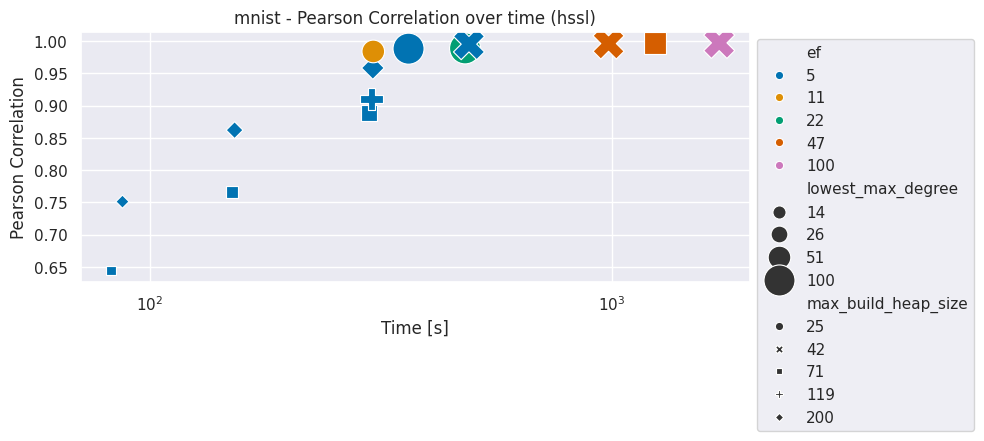

In [29]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnisthssl, x="time", y="Pearson Correlation", 
                hue="ef",
                style="max_build_heap_size", 
                size="lowest_max_degree", 
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - Pearson Correlation over time (hssl)")
plt.xlabel("Time [s]")
plt.ylabel("Pearson Correlation")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST Kruskal

coph_dist took: 41.44376564025879s


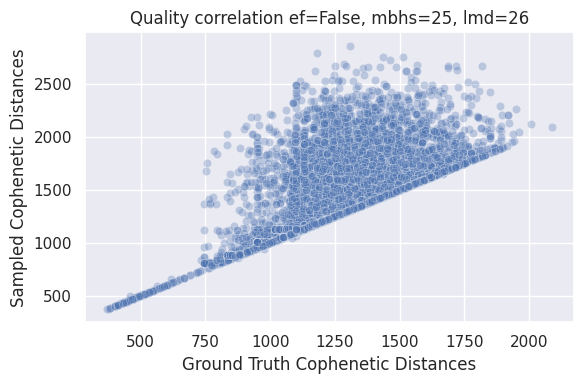

pearson correlation: 0.6494409916244699
cophenetic coefficient: 0.215367217243816
Pearson took: 94.81840682029724s
coph_dist took: 44.16583466529846s


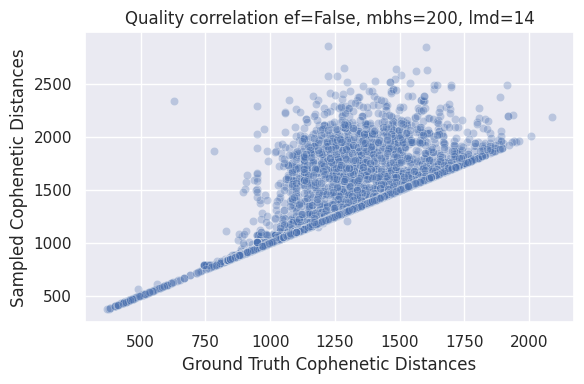

pearson correlation: 0.7558729016847419
cophenetic coefficient: 0.2594189041285382
Pearson took: 97.35072946548462s
coph_dist took: 42.87835359573364s


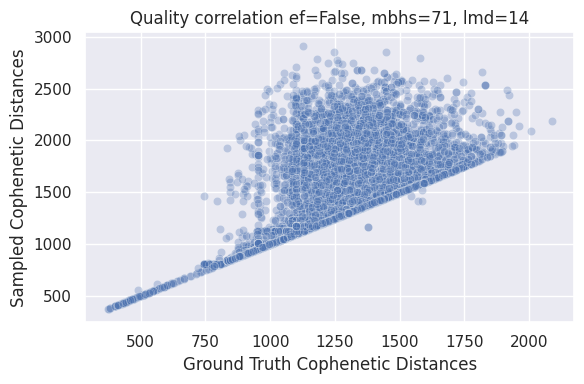

pearson correlation: 0.5969923157497551
cophenetic coefficient: 0.23047258616253904
Pearson took: 96.31781077384949s
coph_dist took: 40.664313316345215s


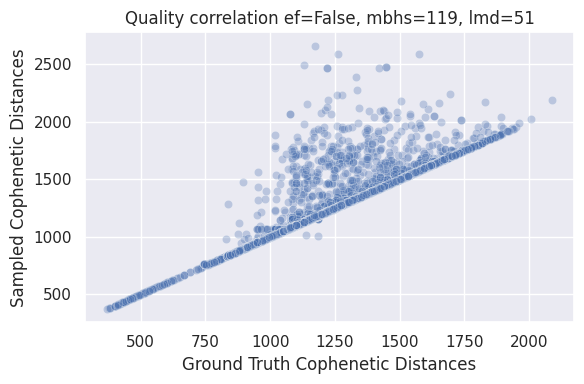

pearson correlation: 0.9208141778985103
cophenetic coefficient: 0.35222438076471585
Pearson took: 94.25125670433044s
coph_dist took: 39.71373915672302s


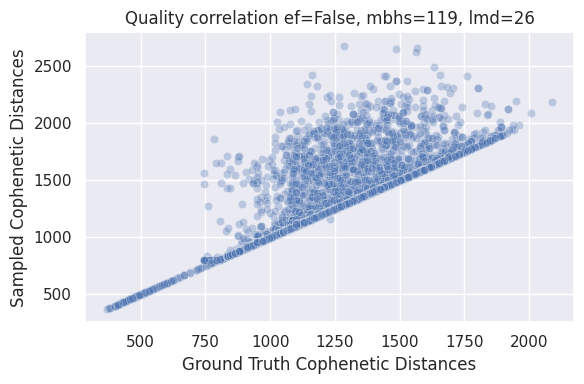

pearson correlation: 0.8051140467673388
cophenetic coefficient: 0.2721163752030761
Pearson took: 92.99945259094238s
coph_dist took: 42.62180233001709s


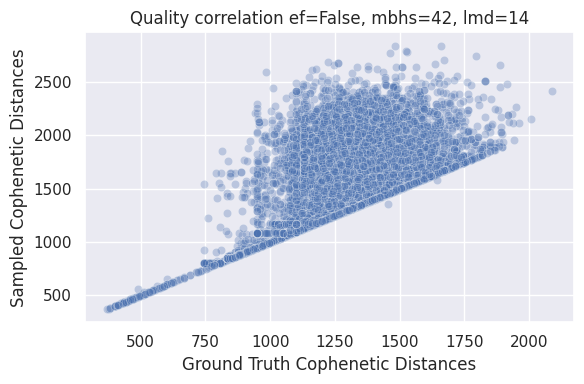

pearson correlation: 0.615862086020376
cophenetic coefficient: 0.2177536701421656
Pearson took: 95.45633625984192s
coph_dist took: 42.5534930229187s


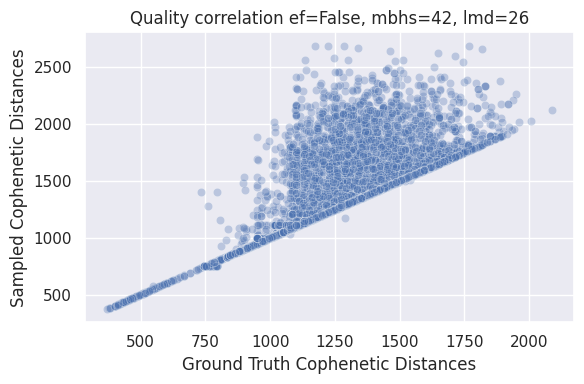

pearson correlation: 0.7521217665925156
cophenetic coefficient: 0.2629840801839113
Pearson took: 95.19750547409058s
coph_dist took: 43.38790559768677s


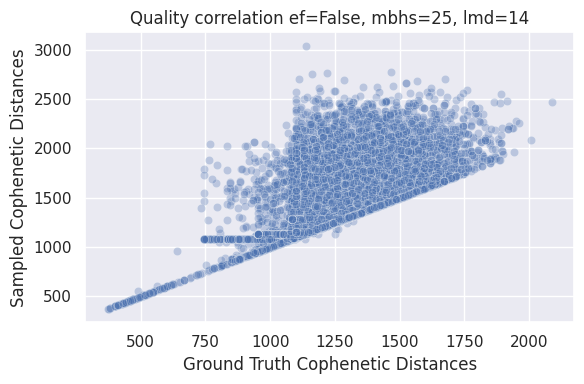

pearson correlation: 0.6287123279465261
cophenetic coefficient: 0.2495869074635469
Pearson took: 96.68520522117615s
coph_dist took: 42.48840808868408s


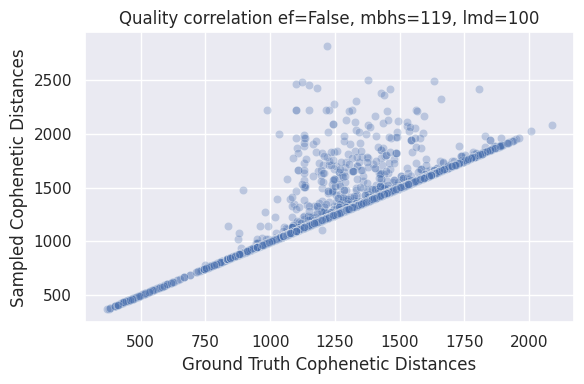

pearson correlation: 0.9361933170861089
cophenetic coefficient: 0.3649995759515844
Pearson took: 96.05544352531433s
coph_dist took: 41.21220517158508s


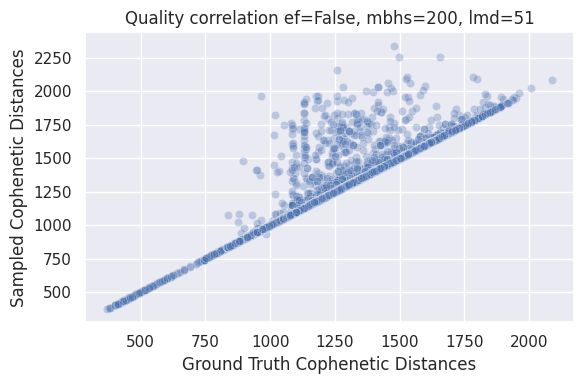

pearson correlation: 0.9364228860635254
cophenetic coefficient: 0.3656618400327329
Pearson took: 94.66604018211365s
coph_dist took: 38.81930351257324s
pearson correlation: 0.6031656140910154
cophenetic coefficient: 0.15860422679182448
Pearson took: 92.07679009437561s
coph_dist took: 38.6218945980072s
pearson correlation: 0.8603157315643161
cophenetic coefficient: 0.3119371084472018
Pearson took: 91.76784348487854s
coph_dist took: 45.869324684143066s
pearson correlation: 0.9867476383168649
cophenetic coefficient: 0.407693632043229
Pearson took: 98.94622135162354s
coph_dist took: 38.5879008769989s
pearson correlation: 0.9861123031899794
cophenetic coefficient: 0.4069824224079277
Pearson took: 89.67101788520813s
coph_dist took: 42.426902532577515s
pearson correlation: 0.9608260929418079
cophenetic coefficient: 0.3838117623985184
Pearson took: 94.9531090259552s
coph_dist took: 46.529529094696045s
pearson correlation: 0.7150876169923776
cophenetic coefficient: 0.246979699458477
Pearson took

algo       time      n  \
0  HNSWkruskal  15.554245  70000   
1  HNSWkruskal  16.572302  70000   
2  HNSWkruskal  15.253799  70000   
3  HNSWkruskal  23.377166  70000   
4  HNSWkruskal  15.705465  70000   

                                              params  Pearson Correlation  \
0  {"minPts": 1, "symmetric_expand": false, "para...             0.649441   
1  {"minPts": 1, "symmetric_expand": false, "para...             0.755873   
2  {"minPts": 1, "symmetric_expand": false, "para...             0.596992   
3  {"minPts": 1, "symmetric_expand": false, "para...             0.920814   
4  {"minPts": 1, "symmetric_expand": false, "para...             0.805114   

   pval  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [30]:
## -- mnist-kruskal -- ##
import time
import itertools

dataset = 'mnist-70k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWkruskal": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1
            continue

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        pear_corr, p_val = pearsonr(sampled_gt_coph_dists, sampled_coph_dists)
        coph_coeff, _ = cophenet(dendro, dist_mat)
        print(f"pearson correlation: {pear_corr}")
        print(f"cophenetic coefficient: {coph_coeff}")
        end = time.time()
        t = end - start
        print(f"Pearson took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "Pearson Correlation": pear_corr,
        "pval": p_val
        })
    finally:
        f.close()

print(error_count)
df_MNISTkruskal = pd.DataFrame(data=data)
df_MNISTkruskal.head(5)

In [31]:
df_MNISTkruskal_split = df_MNISTkruskal
df_MNISTkruskal_split["params_dict"] = df_MNISTkruskal_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISTkruskal_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_MNISTkruskal_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISTkruskal_split = pd.concat([df_MNISTkruskal_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISTkruskal_split

algo       time      n  \
0   HNSWkruskal  15.554245  70000   
1   HNSWkruskal  16.572302  70000   
2   HNSWkruskal  15.253799  70000   
3   HNSWkruskal  23.377166  70000   
4   HNSWkruskal  15.705465  70000   
5   HNSWkruskal  17.661479  70000   
6   HNSWkruskal  14.391205  70000   
7   HNSWkruskal  16.918314  70000   
8   HNSWkruskal  33.872446  70000   
9   HNSWkruskal  25.552272  70000   
10  HNSWkruskal  14.974581  70000   
11  HNSWkruskal  21.577345  70000   
12  HNSWkruskal  27.754680  70000   
13  HNSWkruskal  33.217834  70000   
14  HNSWkruskal  33.386465  70000   
15  HNSWkruskal  16.113104  70000   
16  HNSWkruskal  17.429884  70000   
17  HNSWkruskal  23.621367  70000   
18  HNSWkruskal  21.729967  70000   
19  HNSWkruskal  22.835749  70000   

                                               params  Pearson Correlation  \
0   {"minPts": 1, "symmetric_expand": false, "para...             0.649441   
1   {"minPts": 1, "symmetric_expand": false, "para...             0.755873   
2   {"minPts": 1, "symmetric_expand": false, "para...             0.596992   
3   {"minPts": 1, "symmetric_expand": false, "para...             0.920814   
4   {"minPts": 1, "symmetric_expand": false, "para...             0.805114   
5   {"minPts": 1, "symmetric_expand": false, "para...             0.615862   
6   {"minPts": 1, "symmetric_expand": false, "para...             0.752122   
7   {"minPts": 1, "symmetric_expand": false, "para...             0.628712   
8   {"minPts": 1, "symmetric_expand": false, "para...             0.936193   
9   {"minPts": 1, "symmetric_expand": false, "para...             0.936423   
10  {"minPts": 1, "symmetric_expand": false, "para...             0.603166   
11  {"minPts": 1, "symmetric_expand": false, "para...             0.860316   
12  {"minPts": 1, "symmetric_expand": false, "para...             0.986748   
13  {"minPts": 1, "symmetric_expand": false, "para...             0.986112   
14  {"minPts": 1, "symmetric_expand": false, "para...             0.960826   
15  {"minPts": 1, "symmetric_expand": false, "para...             0.715088   
16  {"minPts": 1, "symmetric_expand": false, "para...             0.876709   
17  {"minPts": 1, "symmetric_expand": false, "para...             0.981004   
18  {"minPts": 1, "symmetric_expand": false, "para...             0.979748   
19  {"minPts": 1, "symmetric_expand": false, "para...             0.948237   

    pval                                        params_dict  symmetric_expand  \
0    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18   0.0  {'minPts': 1, 'symmetric_expand': False, 'par

In [32]:
df_MNISTkruskal_split.to_csv('MNISTkruskal_pearson.csv', index=False)

In [33]:
df_MNISTkruskal_split = df_MNISTkruskal_split[["algo", "time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnistkruskal = get_pareto_frontier(df_MNISTkruskal_split, "time", "Pearson Correlation", "algo")

pareto_mnistkruskal[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
0   14.391205             0.752122             False                   42   
4   15.705465             0.805114             False                  119   
8   17.429884             0.876709             False                  200   
11  21.729967             0.979748             False                   25   
14  23.621367             0.981004             False                   25   
16  27.754680             0.986748             False                   42   

    lowest_max_degree  
0                  26  
4                  26  
8                  26  
11                 51  
14                100  
16                100

In [34]:
filtered_df = pareto_mnistkruskal[pareto_mnistkruskal["Pearson Correlation"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
4  15.705465             0.805114             False                  119   

   lowest_max_degree  
4                 26

In [35]:
pareto_mnistkruskal = pareto_mnistkruskal[["time", "Pearson Correlation", "max_build_heap_size", "lowest_max_degree"]]

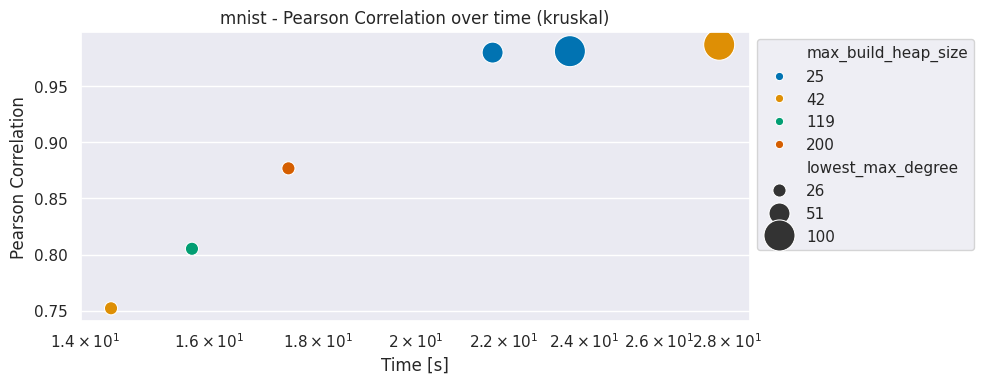

In [36]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnistkruskal, x="time", y="Pearson Correlation", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - Pearson Correlation over time (kruskal)")
plt.xlabel("Time [s]")
plt.ylabel("Pearson Correlation")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST MST

coph_dist took: 38.89240384101868s


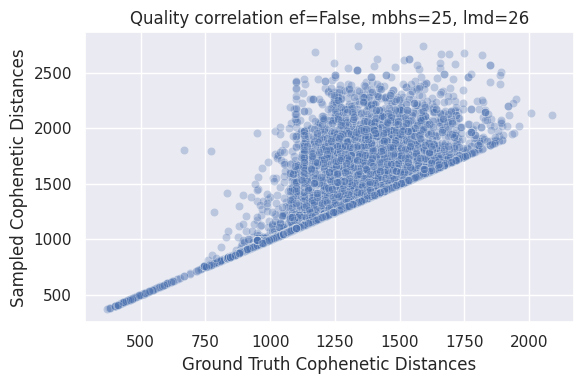

pearson correlation: 0.737315304815997
cophenetic coefficient: 0.2657339242031243
Pearson took: 91.80972170829773s
coph_dist took: 38.88751196861267s


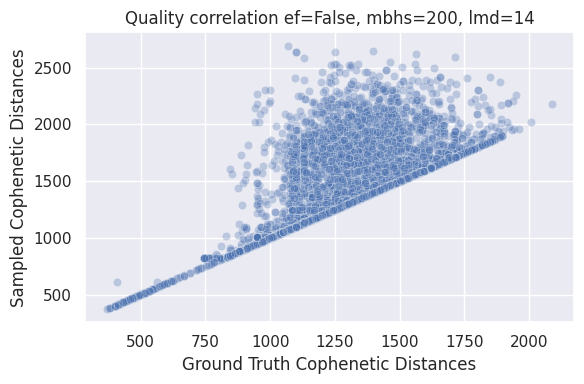

pearson correlation: 0.73517129168984
cophenetic coefficient: 0.24050568186348806
Pearson took: 91.86242294311523s
coph_dist took: 39.114763498306274s


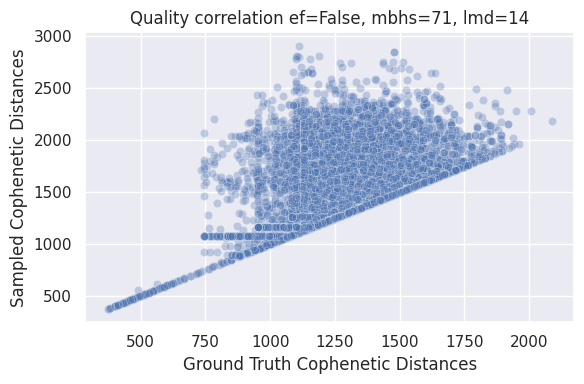

pearson correlation: 0.5080770492701668
cophenetic coefficient: 0.15419468997867364
Pearson took: 92.1050443649292s
coph_dist took: 38.627920150756836s


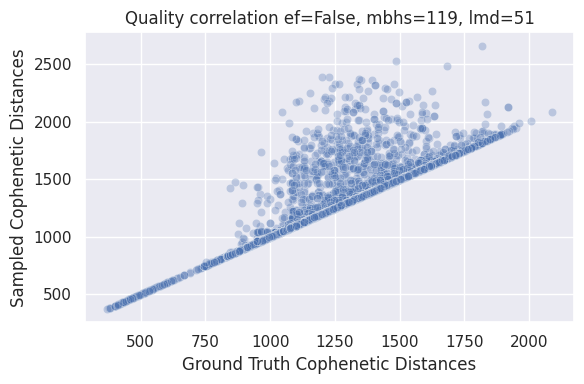

pearson correlation: 0.8859333714242167
cophenetic coefficient: 0.3325098273257419
Pearson took: 91.55655980110168s
coph_dist took: 44.94162321090698s


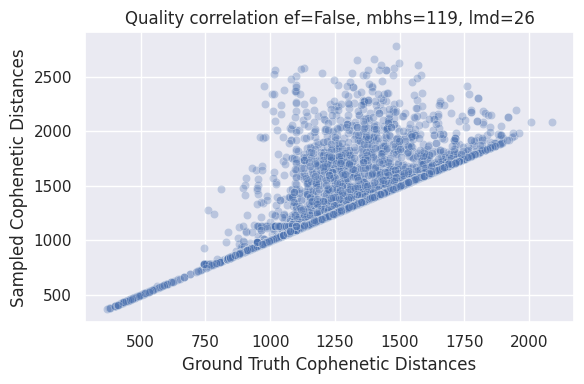

pearson correlation: 0.7871709382178498
cophenetic coefficient: 0.27303240135048096
Pearson took: 97.92595839500427s
coph_dist took: 39.03923678398132s


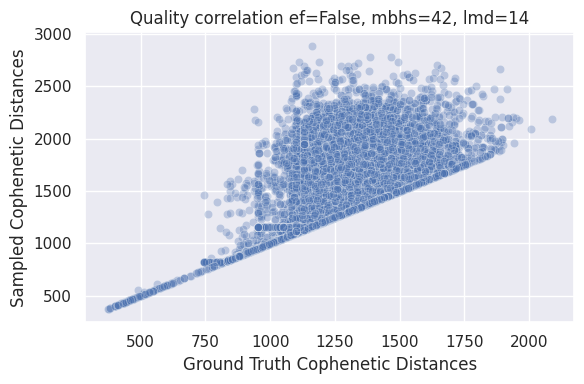

pearson correlation: 0.6110057816317902
cophenetic coefficient: 0.22255440434218687
Pearson took: 90.13758206367493s
coph_dist took: 38.80796241760254s


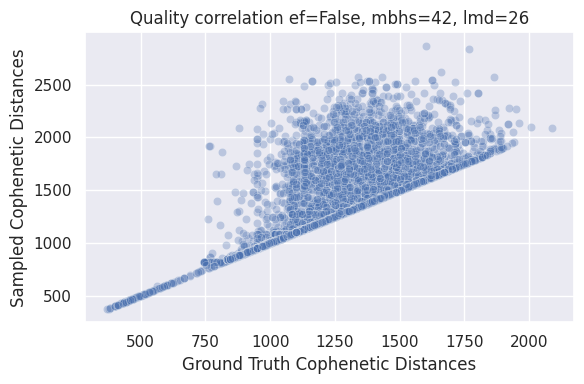

pearson correlation: 0.7137560801127155
cophenetic coefficient: 0.23321504038867544
Pearson took: 90.35863161087036s
coph_dist took: 39.27204871177673s


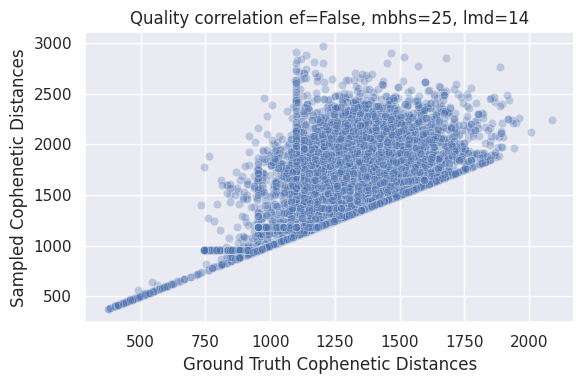

pearson correlation: 0.6078728146034283
cophenetic coefficient: 0.2572828913851222
Pearson took: 90.54507565498352s
coph_dist took: 38.68391394615173s


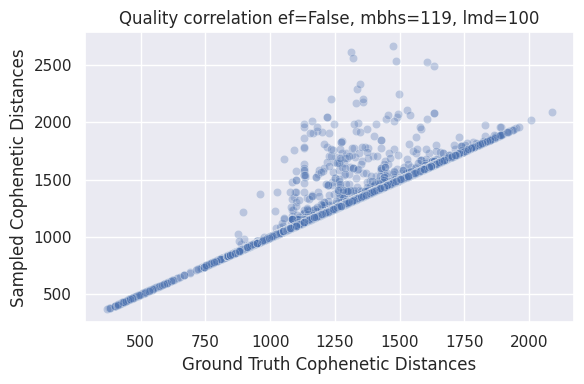

pearson correlation: 0.9544621556545714
cophenetic coefficient: 0.3812306249609215
Pearson took: 89.86504173278809s
coph_dist took: 38.7706024646759s


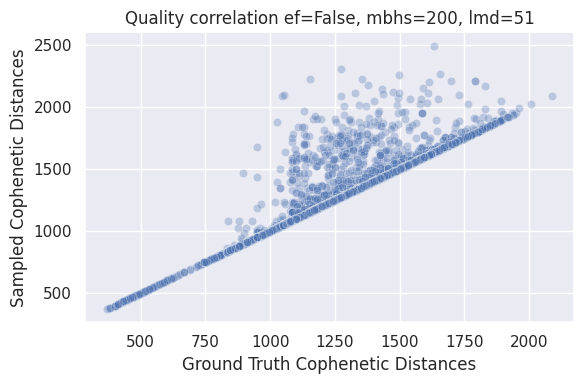

pearson correlation: 0.9299408330777896
cophenetic coefficient: 0.3605434918250616
Pearson took: 89.9770839214325s
coph_dist took: 38.74349641799927s
pearson correlation: 0.7965895850128231
cophenetic coefficient: 0.27223328867318614
Pearson took: 90.07804417610168s
coph_dist took: 47.61609888076782s
pearson correlation: 0.9028033712066464
cophenetic coefficient: 0.3316419794742284
Pearson took: 100.60274338722229s
coph_dist took: 38.700302600860596s
pearson correlation: 0.9877708913921124
cophenetic coefficient: 0.40550087934823575
Pearson took: 91.81215238571167s
coph_dist took: 38.57633876800537s
pearson correlation: 0.9803378833368405
cophenetic coefficient: 0.40113887468463993
Pearson took: 91.59685516357422s
coph_dist took: 38.80628967285156s
pearson correlation: 0.9745393672499749
cophenetic coefficient: 0.39645040616027194
Pearson took: 91.79847478866577s
coph_dist took: 38.93858218193054s
pearson correlation: 0.7303087081707949
cophenetic coefficient: 0.26081535817023893
Pears

algo      time      n  \
0  HNSWmst  1.840610  70000   
1  HNSWmst  2.985336  70000   
2  HNSWmst  1.681333  70000   
3  HNSWmst  4.734183  70000   
4  HNSWmst  3.143082  70000   

                                              params  Pearson Correlation  \
0  {"minPts": 1, "symmetric_expand": false, "para...             0.737315   
1  {"minPts": 1, "symmetric_expand": false, "para...             0.735171   
2  {"minPts": 1, "symmetric_expand": false, "para...             0.508077   
3  {"minPts": 1, "symmetric_expand": false, "para...             0.885933   
4  {"minPts": 1, "symmetric_expand": false, "para...             0.787171   

   pval  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [37]:
## -- mnist-mst -- ##
import time
import itertools

dataset = 'mnist-70k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWmst": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1
            continue

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        pear_corr, p_val = pearsonr(sampled_gt_coph_dists, sampled_coph_dists)
        coph_coeff, _ = cophenet(dendro, dist_mat)
        print(f"pearson correlation: {pear_corr}")
        print(f"cophenetic coefficient: {coph_coeff}")
        end = time.time()
        t = end - start
        print(f"Pearson took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "Pearson Correlation": pear_corr,
        "pval": p_val
        })
    finally:
        f.close()

print(error_count)
df_MNISTmst = pd.DataFrame(data=data)
df_MNISTmst.head(5)

In [38]:
df_MNISTmst_split = df_MNISTmst
df_MNISTmst_split["params_dict"] = df_MNISTmst_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISTmst_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_MNISTmst_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISTmst_split = pd.concat([df_MNISTmst_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISTmst_split

algo      time      n  \
0   HNSWmst  1.840610  70000   
1   HNSWmst  2.985336  70000   
2   HNSWmst  1.681333  70000   
3   HNSWmst  4.734183  70000   
4   HNSWmst  3.143082  70000   
5   HNSWmst  1.290381  70000   
6   HNSWmst  2.108674  70000   
7   HNSWmst  1.099854  70000   
8   HNSWmst  7.304697  70000   
9   HNSWmst  6.050233  70000   
10  HNSWmst  2.581286  70000   
11  HNSWmst  3.806858  70000   
12  HNSWmst  4.423545  70000   
13  HNSWmst  6.184672  70000   
14  HNSWmst  8.978653  70000   
15  HNSWmst  2.254181  70000   
16  HNSWmst  4.120671  70000   
17  HNSWmst  2.781672  70000   
18  HNSWmst  2.438128  70000   
19  HNSWmst  3.261788  70000   

                                               params  Pearson Correlation  \
0   {"minPts": 1, "symmetric_expand": false, "para...             0.737315   
1   {"minPts": 1, "symmetric_expand": false, "para...             0.735171   
2   {"minPts": 1, "symmetric_expand": false, "para...             0.508077   
3   {"minPts": 1, "symmetric_expand": false, "para...             0.885933   
4   {"minPts": 1, "symmetric_expand": false, "para...             0.787171   
5   {"minPts": 1, "symmetric_expand": false, "para...             0.611006   
6   {"minPts": 1, "symmetric_expand": false, "para...             0.713756   
7   {"minPts": 1, "symmetric_expand": false, "para...             0.607873   
8   {"minPts": 1, "symmetric_expand": false, "para...             0.954462   
9   {"minPts": 1, "symmetric_expand": false, "para...             0.929941   
10  {"minPts": 1, "symmetric_expand": false, "para...             0.796590   
11  {"minPts": 1, "symmetric_expand": false, "para...             0.902803   
12  {"minPts": 1, "symmetric_expand": false, "para...             0.987771   
13  {"minPts": 1, "symmetric_expand": false, "para...             0.980338   
14  {"minPts": 1, "symmetric_expand": false, "para...             0.974539   
15  {"minPts": 1, "symmetric_expand": false, "para...             0.730309   
16  {"minPts": 1, "symmetric_expand": false, "para...             0.858110   
17  {"minPts": 1, "symmetric_expand": false, "para...             0.979818   
18  {"minPts": 1, "symmetric_expand": false, "para...             0.970885   
19  {"minPts": 1, "symmetric_expand": false, "para...             0.963520   

    pval                                        params_dict  symmetric_expand  \
0    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9    0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19   0.0  {'minPts': 1, 'symmetric_expand': False, 'para...             Fal

In [39]:
df_MNISTmst_split.to_csv('MNISTmst_pearson.csv', index=False)

In [40]:
df_MNISTmst_split = df_MNISTmst_split[["algo", "time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnistmst = get_pareto_frontier(df_MNISTmst_split, "time", "Pearson Correlation", "algo")

pareto_mnistmst[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
0   1.099854             0.607873             False                   25   
1   1.290381             0.611006             False                   42   
3   1.840610             0.737315             False                   25   
6   2.438128             0.970885             False                   25   
8   2.781672             0.979818             False                   25   
14  4.423545             0.987771             False                   42   

    lowest_max_degree  
0                  14  
1                  14  
3                  26  
6                  51  
8                 100  
14                100

In [41]:
filtered_df = pareto_mnistmst[pareto_mnistmst["Pearson Correlation"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "Pearson Correlation", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  Pearson Correlation  symmetric_expand  max_build_heap_size  \
6  2.438128             0.970885             False                   25   

   lowest_max_degree  
6                 51

In [42]:
pareto_mnistmst = pareto_mnistmst[["time", "Pearson Correlation", "max_build_heap_size", "lowest_max_degree"]]

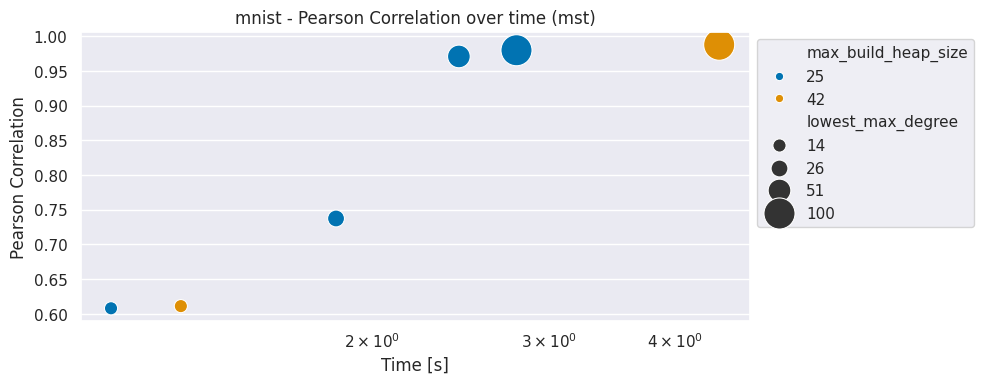

In [43]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnistmst, x="time", y="Pearson Correlation", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - Pearson Correlation over time (mst)")
plt.xlabel("Time [s]")
plt.ylabel("Pearson Correlation")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

# break

In [ ]:
# df_ALOIhssl = pd.read_csv("ALOIhssl.csv")
# df_ALOIkruskal = pd.read_csv("ALOIkruskal.csv")
# df_ALOImst = pd.read_csv("ALOImst.csv")
# df_MNISThssl = pd.read_csv("MNISThssl.csv")
# df_MNISTkruskal = pd.read_csv("MNISTkruskal.csv")
# df_MNISTmst = pd.read_csv("MNISTmst.csv")